In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Generator Model
from tensorflow.keras import layers, models

def build_generator(z_dim):
    model = tf.keras.Sequential()

    # Dense layer to expand latent vector to a larger feature space
    model.add(layers.Dense(128, input_dim=z_dim))
    model.add(layers.LeakyReLU(alpha=0.2))  # LeakyReLU for non-linearity
    model.add(layers.BatchNormalization(momentum=0.8))

    # Upsampling to larger feature maps
    model.add(layers.Dense(7 * 7 * 64))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Reshape((7, 7, 64)))

    # Upsample to the target size of 28x28 using Conv2DTranspose layers
    model.add(layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))

    # Output layer: 1 channel, 28x28 image with a tanh activation (scaled between -1 and 1)
    model.add(layers.Conv2DTranspose(1, kernel_size=7, activation='tanh', padding='same'))

    return model

import tensorflow as tf
from tensorflow.keras import layers

def build_generator(z_dim):
    model = tf.keras.Sequential()

    # Fully connected layer
    model.add(layers.Dense(7 * 7 * 128, activation='relu', input_dim=z_dim))
    model.add(layers.Reshape((7, 7, 128)))  # Reshape to 7x7x128

    # Upsampling with transpose convolutions
    model.add(layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding='same', activation='relu'))
    model.add(layers.BatchNormalization(momentum=0.8))

    model.add(layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', activation='relu'))
    model.add(layers.BatchNormalization(momentum=0.8))

    model.add(layers.Conv2DTranspose(32, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(layers.BatchNormalization(momentum=0.8))

    # Final layer to produce 28x28 image
    model.add(layers.Conv2DTranspose(1, kernel_size=5, strides=1, padding='same', activation='tanh'))  # 'tanh' to normalize [-1, 1]

    return model




# Discriminator Model
def build_discriminator(input_shape=(28, 28, 1)):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, kernel_size=5, activation='relu', input_shape=input_shape,padding='same'))
    model.add(layers.MaxPool2D())
    model.add(layers.Dropout(0.3))  # Dropout of 30% for regularization

    model.add(layers.Conv2D(64, kernel_size=5, activation='relu', padding='same'))
    model.add(layers.MaxPool2D())
    model.add(layers.Dropout(0.4))  # Increasing dropout to prevent overfitting

    model.add(layers.Conv2D(128, kernel_size=5, activation='relu', padding='same'))
    model.add(layers.MaxPool2D())
    model.add(layers.Dropout(0.5))  # Further regularization

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.4))  # Dropout in dense layers

    model.add(layers.Dense(1, activation='sigmoid'))  # Sigmoid for binary classification (real or fake)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# GAN Model (combining generator and discriminator)
def build_gan(generator, discriminator):
    # Freeze the discriminator's weights while training the generator
    discriminator.trainable = False

    model = tf.keras.Sequential()
    model.add(generator)
    model.add(discriminator)

    return model


In [ ]:
def generator_loss(fake_output):
    return tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.binary_crossentropy(0.9 * tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss


In [ ]:

from keras.optimizers.schedules import ExponentialDecay
lr_schedule_gen = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0003,
    decay_steps=20000,
    decay_rate=0.9,
    staircase=True
)
lr_schedule_disc = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.00007,
    decay_steps=20000,
    decay_rate=0.8,
    staircase=True
)

@tf.function
def train_step(real_images, z_dim):
    # Create random noise for the generator
    batch_size = real_images.shape[0]
    random_latent_vectors = tf.random.normal(shape=(batch_size, z_dim))

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images from the random noise
        generated_images = generator(random_latent_vectors, training=True)

        # Get discriminator predictions for both real and fake images
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Calculate losses
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Get gradients for the generator and discriminator
    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradients to the models
    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11055112049123774644
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12398076163699612400
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [ ]:
# Define the generator and discriminator models
generator = build_generator(z_dim=100)
discriminator = build_discriminator()

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule_gen)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule_disc)

@tf.function
def train_step(real_images, z_dim, generator, discriminator):
    # Create random noise for the generator
    batch_size = real_images.shape[0]
    random_latent_vectors = tf.random.normal(shape=(batch_size, z_dim))

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images from the random noise
        generated_images = generator(random_latent_vectors, training=True)

        # Get discriminator predictions for both real and fake images
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Calculate losses
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Get gradients for the generator and discriminator
    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradients to the models
    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    return gen_loss, disc_loss


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch: 5
  Generator Loss (Avg): 1.4346
  Discriminator Loss (Avg): 1.0103


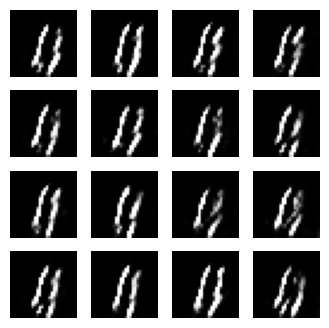

Epoch: 10
  Generator Loss (Avg): 1.7835
  Discriminator Loss (Avg): 0.8701


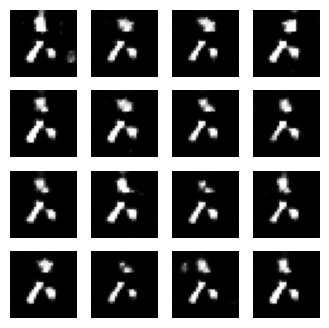

Epoch: 15
  Generator Loss (Avg): 1.8866
  Discriminator Loss (Avg): 0.8409


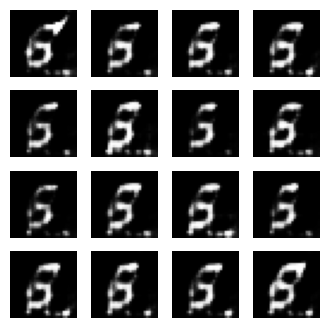

Epoch: 20
  Generator Loss (Avg): 2.6016
  Discriminator Loss (Avg): 0.7219


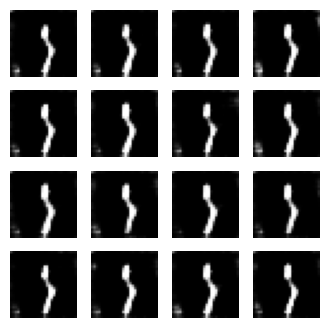

Epoch: 25
  Generator Loss (Avg): 2.5097
  Discriminator Loss (Avg): 0.7530


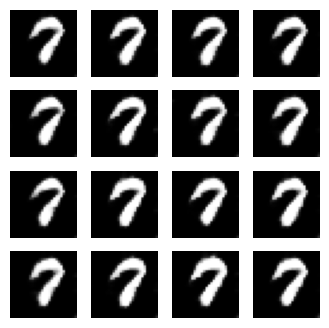

Epoch: 30
  Generator Loss (Avg): 3.2404
  Discriminator Loss (Avg): 0.5983


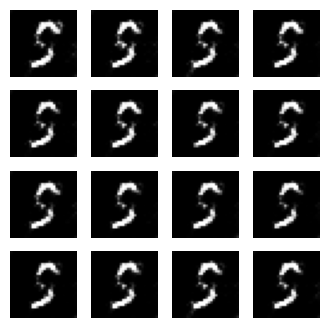

Epoch: 35
  Generator Loss (Avg): 3.9382
  Discriminator Loss (Avg): 0.5201


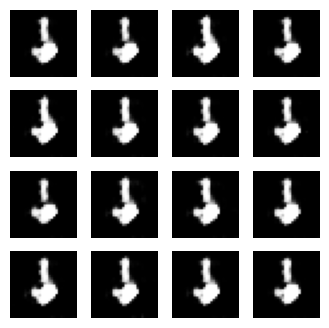

Epoch: 40
  Generator Loss (Avg): 3.9554
  Discriminator Loss (Avg): 0.5114


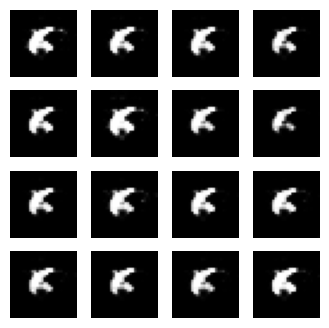

Epoch: 45
  Generator Loss (Avg): 4.0552
  Discriminator Loss (Avg): 0.5505


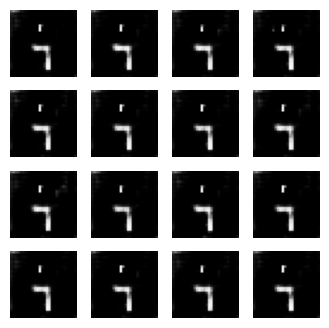

Epoch: 50
  Generator Loss (Avg): 4.2489
  Discriminator Loss (Avg): 0.5447


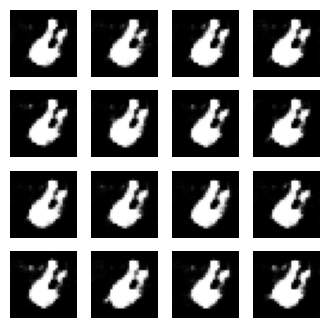

Epoch: 55
  Generator Loss (Avg): 2.5390
  Discriminator Loss (Avg): 0.6513


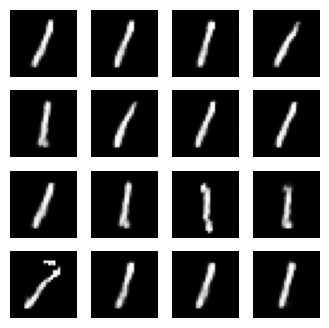

Epoch: 60
  Generator Loss (Avg): 2.7492
  Discriminator Loss (Avg): 0.6651


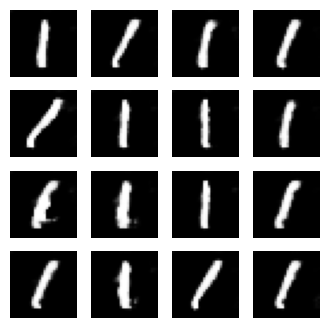

Epoch: 65
  Generator Loss (Avg): 2.2517
  Discriminator Loss (Avg): 0.7402


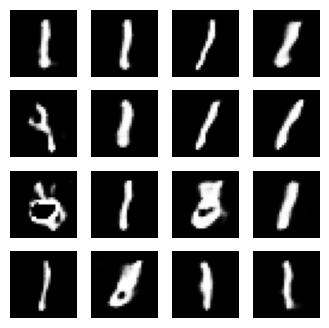

Epoch: 70
  Generator Loss (Avg): 2.1837
  Discriminator Loss (Avg): 0.8251


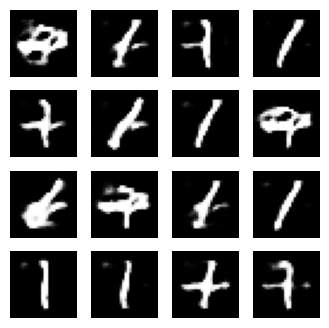

Epoch: 75
  Generator Loss (Avg): 2.0645
  Discriminator Loss (Avg): 0.8304


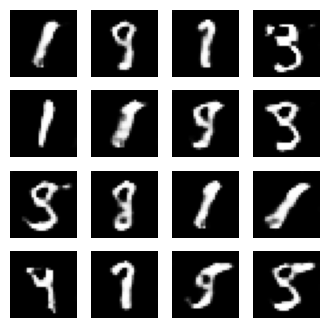

Epoch: 80
  Generator Loss (Avg): 1.8710
  Discriminator Loss (Avg): 0.8894


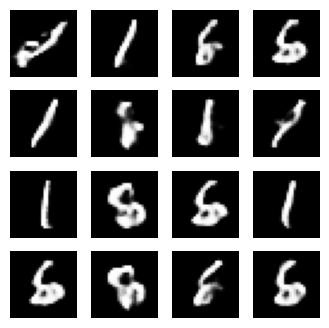

Epoch: 85
  Generator Loss (Avg): 1.9353
  Discriminator Loss (Avg): 0.8516


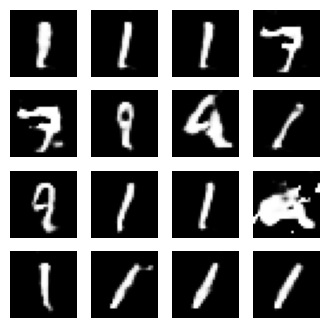

Epoch: 90
  Generator Loss (Avg): 1.7625
  Discriminator Loss (Avg): 0.9431


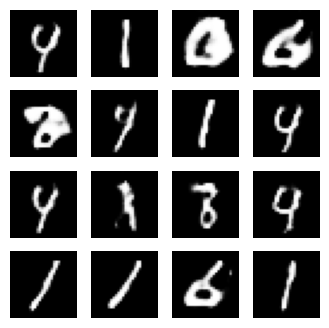

Epoch: 95
  Generator Loss (Avg): 1.6643
  Discriminator Loss (Avg): 0.9720


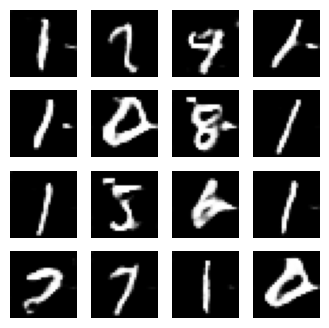

Epoch: 100
  Generator Loss (Avg): 1.6869
  Discriminator Loss (Avg): 0.9439


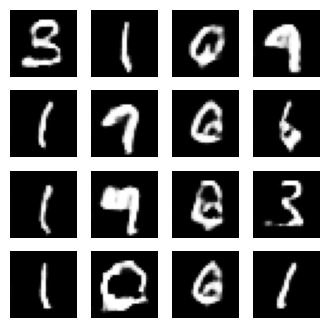

Epoch: 105
  Generator Loss (Avg): 1.6302
  Discriminator Loss (Avg): 1.0028


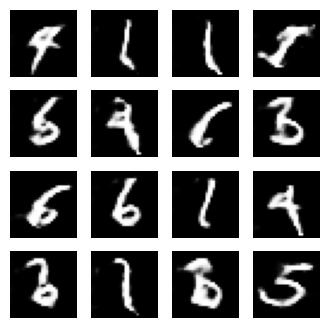

Epoch: 110
  Generator Loss (Avg): 1.7189
  Discriminator Loss (Avg): 0.9439


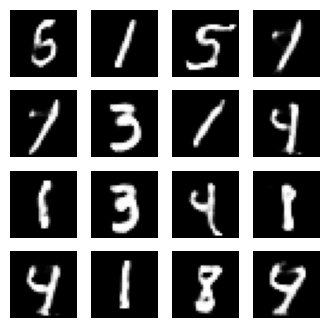

Epoch: 115
  Generator Loss (Avg): 1.8569
  Discriminator Loss (Avg): 0.9148


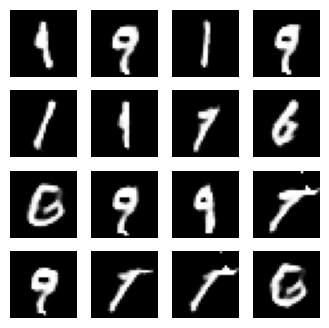

Epoch: 120
  Generator Loss (Avg): 1.7782
  Discriminator Loss (Avg): 0.9042


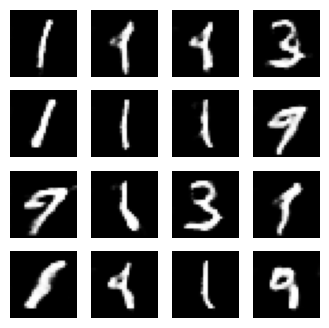

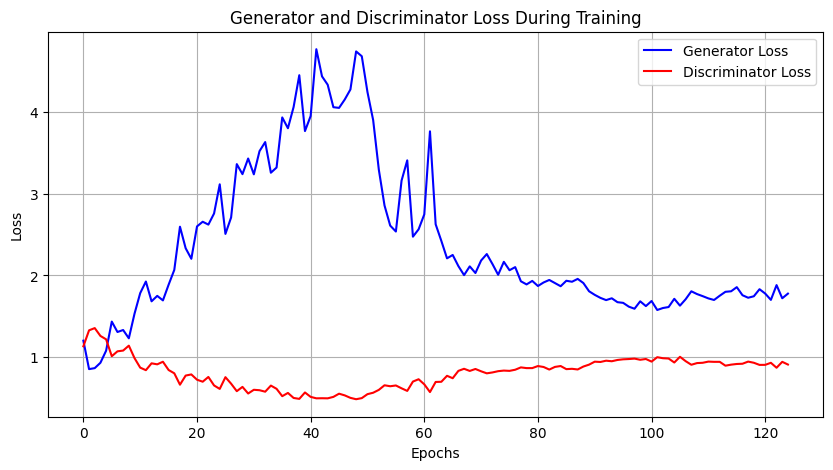

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Training loop
epochs = 125
batch_size = 64
z_dim = 100

# Load MNIST dataset
(X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = X_train[:20000]
X_train = X_train / 127.5 - 1.0  # Normalize to [-1, 1]
X_train = np.expand_dims(X_train, axis=-1)  # Add channel dimension

# Initialize lists to store the losses for each epoch
gen_loss_history = []
disc_loss_history = []

# Train the GAN
for epoch in range(epochs):
    gen_losses = []
    disc_losses = []

    for i in range(0, len(X_train), batch_size):
        real_images = X_train[i:i+batch_size]

        gen_loss, disc_loss = train_step(real_images, z_dim, generator, discriminator)

        # Append scalar loss values to lists
        gen_losses.append(gen_loss.numpy().mean())  # Ensure scalar value is appended
        disc_losses.append(disc_loss.numpy().mean())  # Ensure scalar value is appended

    # Compute average losses for the epoch
    avg_gen_loss = np.mean(gen_losses)
    avg_disc_loss = np.mean(disc_losses)

    # Store the average losses for visualization
    gen_loss_history.append(avg_gen_loss)
    disc_loss_history.append(avg_disc_loss)

    # Print losses and save generated images periodically
    if epoch % 5 == 0 and epoch >= 5:
        print(f'Epoch: {epoch}')
        print(f'  Generator Loss (Avg): {avg_gen_loss:.4f}')
        print(f'  Discriminator Loss (Avg): {avg_disc_loss:.4f}')

        # Generate and display some sample images
        random_latent_vectors = tf.random.normal(shape=(16, z_dim))
        generated_images = generator(random_latent_vectors, training=False)

        # Rescale to [0, 1]
        generated_images = (generated_images + 1) / 2.0
        plt.figure(figsize=(4, 4))
        for i in range(generated_images.shape[0]):
            plt.subplot(4, 4, i+1)
            plt.imshow(generated_images[i, :, :, 0], cmap='gray')
            plt.axis('off')
        plt.show()

# After training, visualize the loss
plt.figure(figsize=(10, 5))

# Plot Generator and Discriminator loss
plt.plot(range(epochs), gen_loss_history, label='Generator Loss', color='blue')
plt.plot(range(epochs), disc_loss_history, label='Discriminator Loss', color='red')

# Add labels and title
plt.title('Generator and Discriminator Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.98      0.88      1000
           1       0.98      0.75      0.85      1000

    accuracy                           0.87      2000
   macro avg       0.89      0.87      0.86      2000
weighted avg       0.89      0.87      0.86      2000

Confusion Matrix:
[[981  19]
 [248 752]]

Confusion Matrix (Text Illustration):
True Positives (TP): 752
False Positives (FP): 19
False Negatives (FN): 248
True Negatives (TN): 981


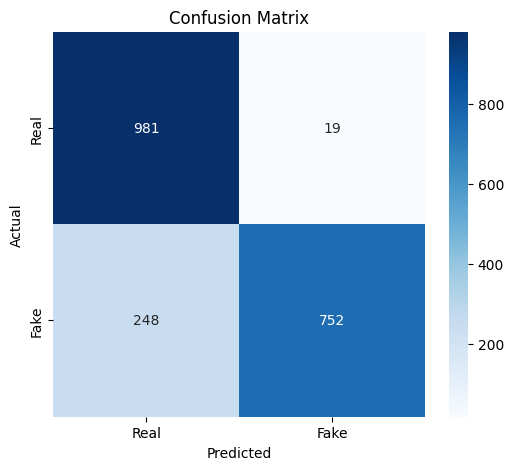

In [ ]:
num_fake_images = 1000
fake_images = generator.predict(np.random.normal(0, 1, (num_fake_images, z_dim)))

# Confusion matrix and classification report
y_true = np.array([1] * 1000 + [0] * num_fake_images)  # 1 for real, 0 for fake
y_pred = np.concatenate([discriminator.predict(X_train[:1000]) > 0.5,
                         discriminator.predict(fake_images) > 0.5])

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(y_true, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Print confusion matrix with labels
print("\nConfusion Matrix (Text Illustration):")
print(f"True Positives (TP): {cm[1, 1]}")
print(f"False Positives (FP): {cm[0, 1]}")
print(f"False Negatives (FN): {cm[1, 0]}")
print(f"True Negatives (TN): {cm[0, 0]}")

# Plot confusion matrix for better visualization
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()